# Integration of metabolomics/transcriptomics on Colombia P. Vivax infection data

This is the integration code for

Gardinassi L, Arévalo-Herrera M, Herrera S, Cordy RJ, Tran V, Smith MR, Johnson MS, Chako B, Darley-Usmar VM, Liu K, Go Y, Jones DP, Galinski M, Li S.  (2018) Integrative metabolomics and transcriptomics signatures of clinical tolerance to Plasmodium vivax reveal activation of innate cell  immunity and T cell signaling. Redox Biology. 17:158-170. DOI: 10.1016/j.redox.2018.04.011 PMID: 29698924

https://www.sciencedirect.com/science/article/pii/S2213231718302556

Refactored from MMRN in Li et al. 2017. 
* Using regular hierachical clustering for BTMs
* New weighted distance matrix for metabolomics data, then hierachical clustering
* Manual selection of clusters cutoff here. May automate later


In [46]:
import os
DataDir = 'input_data/'

# inspect data
for f in os.listdir(DataDir):
    print("~~~", f, "~~~")
    print (open(DataDir+f).read().splitlines()[0].split("\t"))
    

('~~~', 'HILIC_pos_diag_basel.txt', '~~~')
['mz_rt', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'SI1', 'SI2', 'SI3', 'SI4', 'SI5', 'SI6']
('~~~', 'HILIC_pos_baseline.txt', '~~~')
['mz', 'time', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'SI1', 'SI2', 'SI3', 'SI4', 'SI5', 'SI6']
('~~~', 'colombia_BTMactivity_basel.txt', '~~~')
['BTM', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'SI1', 'SI2', 'SI3', 'SI4', 'SI5', 'SI6']
('~~~', 'formatted_BTMs_diag_basel.txt', '~~~')
['BTM', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'SI1', 'SI2', 'SI3', 'SI4', 'SI5', 'SI6']


In [47]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

# Start with data at diagnosis/baseline
btm = pd.read_table(DataDir + 'formatted_BTMs_diag_basel.txt')
btm.head()

,BTM,N1,N2,N3,N4,N5,N6,SI1,SI2,SI3,SI4,SI5,SI6
0,integrin cell surface interactions (I) (M1.0),-0.177,0.804,1.866,-1.473,-0.389,1.700,-0.920,0.187,0.540,0.874,-0.240,0.131
1,extracellular matrix (I) (M2.0),-1.286,-0.549,-0.840,-1.526,-0.320,0.196,-0.242,0.223,0.654,0.321,-0.071,-0.441
2,extracellular matrix (II) (M2.1),-0.285,-0.118,0.186,-0.154,0.140,0.158,-0.507,0.277,0.627,0.382,0.030,0.075
3,extracellular matrix (III) (M2.2),-1.286,-0.549,-0.840,-1.526,-0.320,0.196,-0.242,0.223,0.654,0.321,-0.071,-0.441
4,regulation of signal transduction (M3),-0.720,-0.381,0.097,-0.330,0.123,-0.341,-0.525,0.316,0.155,0.140,-0.126,-0.365


((281, 13), (39340,))


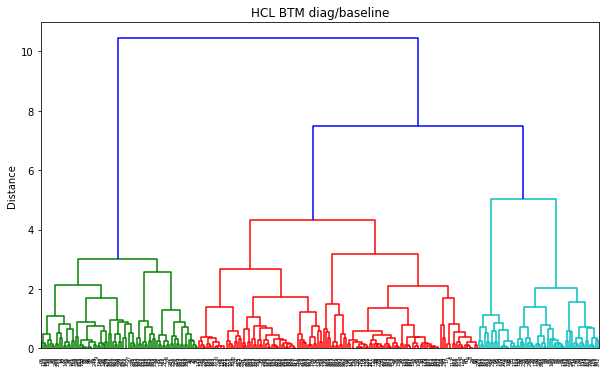

In [48]:
# Scipy implementation of hierarchical clustering is mirroring Matlab
# https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
# https://www.mathworks.com/help/stats/hierarchical-clustering.html

from scipy.cluster.hierarchy import *
from scipy.spatial.distance import pdist

# distance matrix
Y = pdist(btm.values[:, 1:], 'correlation')
print(btm.shape, Y.shape)

# linkage matrix
Z = linkage(Y, method='ward')

plt.figure(figsize=(10, 6))
plt.title('HCL BTM diag/baseline')
plt.ylabel('Distance')
dendrogram(Z)
plt.show()


In [49]:
# based on the figure above, cut the tree at 1
btmClus = fcluster(Z, 1, criterion='distance')

print(btmClus)    # This is cluster number for each row in btm

number_features, number_clusters = len(btmClus), len(set(list(btmClus)))
print("number of features: ", number_features)
print("number of clusters: ", number_clusters)

# Compile clusters
btmClusDict = {}
for ii in range(number_features):
    if btmClusDict.has_key(btmClus[ii]):
        btmClusDict[ btmClus[ii] ].append(ii)
    else:
        btmClusDict[ btmClus[ii] ] = [ii]
        
print(btmClusDict.items()[:3])    # This organizes cluster, members


[ 8 20  9 20 20 20  6  4 20  3  7  6  2  6  2 17 14 20 11  3  3  3  3  7  1
 18  2  6 20 17 17  2 18  1  6 17  1  2 23 12  7  4 23 18 17 23  7  7 26  8
 26 24 24 24 24 24 24 24 24  3 20  8 23  3 19 17 17 17  3 23 13 10 11 26 18
 13  7 18 22 22 22 22 22 20 20 25  9 24 17 22 20 26 23 22 18  1  3  3  4 24
 26  2 20 18 18 22  9 26 14 11 11 11 26  1 18  6  2 20 17 12  8 22 14  8 26
 18 17 17 19 23 23 13 25 24 26 11 11 22 24 11  1  3  8 17  5  5 13  4 18 18
 17  8 17 11 17  9  1 17 17 18 24 11  4  8  9  2 18 13 11  7 17 17  4 21 26
 11 13 20 20 18  5 11  8  8 22  5 11 18  3 18 18 18 11  8 21 21  3  8 26 17
  4 21 18 15 17  7 15 15 12 10 10 12 12 11  7  6 13  9 11  9  4  9  5 26 15
 13  8 21  8 25 16 22  7  7  5  5 20 19  5  7 11 11 26  4 11  4  3 25  3 10
  4  7  5  3  5 23  4 10 11  3 16 11 24  4 14 24 11  4  2  7 22 17 17 17 16
  2 16 21 17 17 23]
('number of features: ', 281)
('number of clusters: ', 26)
[(1, [24, 33, 36, 95, 113, 140, 156]), (2, [12, 14, 26, 31, 37, 101, 116, 165, 268, 2

In [50]:
# do metabolomics data
metabo = pd.read_table(DataDir + 'HILIC_pos_diag_basel.txt')
metabo.head()

,mz_rt,N1,N2,N3,N4,N5,N6,SI1,SI2,SI3,SI4,SI5,SI6
0,85.02865196_275.3154044,-0.741169,-1.394805,-0.620273,0.857773,-1.613470,-0.264445,-1.909026,-0.187610,1.388254,0.878922,-0.934093,2.638685
1,85.02868748_114.3203084,-2.711312,1.161496,5.581955,-0.188379,-0.081080,0.621589,-0.875584,-0.542016,0.730462,1.173231,0.587078,7.605417
2,85.04799534_127.0756394,-0.059953,-5.980863,-0.026952,0.000000,-21.934977,-0.461426,-1.451391,-0.965788,0.979416,0.767319,-0.773038,-21.085978
3,85.06507359_261.7958538,-0.589275,-0.497958,0.441288,-1.408106,0.203421,-1.705279,-0.614097,-1.570598,0.656213,0.304973,0.163556,0.462155
4,85.07627944_160.8882793,-0.348159,-0.509134,-0.330221,0.701595,0.679800,-2.164348,-0.705403,-1.027574,1.476842,0.516237,-0.505817,1.322065


In [104]:
# Clustering of metabolite features
# distance matrix, this is [1 - (Pearson R)]
YM = pdist(metabo.values[:, 1:], 'correlation')
print(metabo.shape, YM.shape)

#
# New method, weighting delta retention time into new distance matrix
#

retention_time = [float(x.split("_")[1]) for x in metabo.values[:,0]]
min_retention_time, max_retention_time = min(retention_time), max(retention_time)
range_retention_time = max_retention_time - min_retention_time
print("min_retention_time, max_retention_time", min_retention_time, max_retention_time)

'''
sanity_check = []    # delta_RT has to be the same order as in YM!
for ii in range(10):
    for jj in range(ii+1, 10):
        sanity_check.append( stats.pearsonr(metabo.values[ii, 1:], metabo.values[jj, 1:])[0] )

print(sanity_check[:20])
'''

PearsonR = 1 - YM
#print(PearsonR[:20])

delta_RT = []
for ii in range(metabo.shape[0]):
    for jj in range(ii+1, metabo.shape[0]):
        delta_RT.append(abs(retention_time[ii] - retention_time[jj]))        

print("Vector delta_RT len: ", len(delta_RT))

#
# weighting function
# distance = 1 - (1 - delta_RT/range_retention_time)*PearsonR
#

YM_new = 1 - (1- np.array(delta_RT)/range_retention_time)*PearsonR

print(PearsonR[:5])
print(delta_RT[:5])
print((1-YM_new)[:5])

# redo something for retrieving :( This will need cleanup
ZM_redo = linkage(YM_new, method='ward')
metClus_redo = fcluster(ZM_redo, 2, criterion='distance')


((4236, 13), (8969730,))
('min_retention_time, max_retention_time', 21.02259976, 284.4340804)
('Vector delta_RT len: ', 8969730)
[ 0.52742797 -0.11448036  0.22389849  0.58368643  0.61589023]
[160.995096, 148.23976499999998, 13.519550600000002, 114.42712509999998, 109.11720049999997]
[ 0.205068   -0.05005438  0.21240694  0.33013043  0.36076005]


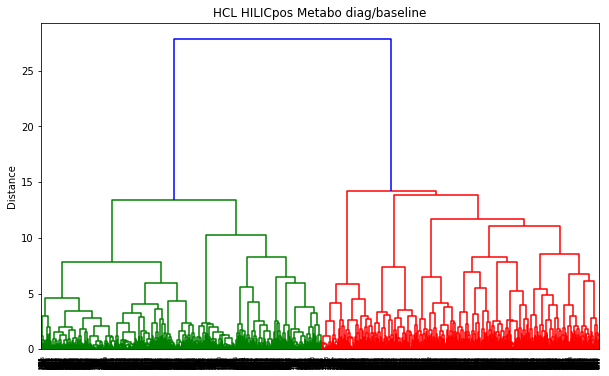

In [52]:
# Metabolite features linkage matrix using new distance matrix
ZM = linkage(YM_new, method='ward')

plt.figure(figsize=(10, 6))
plt.title('HCL HILICpos Metabo diag/baseline')
plt.ylabel('Distance')
dendrogram(ZM)
plt.show()

In [53]:
# based on the figure above, cut the tree at 2
metClus = fcluster(ZM, 2, criterion='distance')
print(metClus[:10])   

number_features, number_clusters = len(metClus), len(set(list(metClus)))
print("number of features: ", number_features)
print("number of clusters: ", number_clusters)

# Compile clusters
metClusDict = {}
for ii in range(number_features):
    if metClusDict.has_key(metClus[ii]):
        metClusDict[ metClus[ii] ].append(ii)
    else:
        metClusDict[ metClus[ii] ] = [ii]
        
print(metClusDict.items()[:3])    # This organizes cluster, members

[ 24  26  65  37 104   1  24  41  40   6]
('number of features: ', 4236)
('number of clusters: ', 111)
[(1, [5, 85, 88, 89, 126, 242, 306, 389, 469, 483, 517, 529, 583, 605, 632, 682, 692, 711, 724, 778, 780, 782, 834, 874, 896, 917, 975, 1104, 1215, 1340, 1458, 1473, 1600, 1781, 1837, 2312, 2757, 3061, 3115, 3367]), (2, [319, 322, 372, 401, 451, 506, 738, 1527, 1767, 1799, 1808, 1830, 1891, 1892, 1894, 1931, 1948, 2258, 2307, 2558, 2798, 2843, 2930, 2969, 2974, 3045, 3094, 3427, 3522, 3545, 3556, 3576, 3618, 3624, 3671, 3706, 4022, 4025, 4057]), (3, [11, 21, 62, 74, 81, 91, 165, 186, 188, 202, 205, 235, 276, 279, 321, 335, 336, 348, 349, 373, 381, 466, 495, 508, 514, 532, 533, 619, 648, 662, 672, 677, 679, 687, 701, 761, 779, 813, 828, 839, 845, 851, 866, 875, 886, 899, 936, 960, 980, 989, 995, 1051, 1069, 1076, 1103, 1166, 1188, 1211, 1221, 1228, 1259, 1284, 1285, 1290, 1295, 1305, 1314, 1333, 1381, 1403, 1415, 1432, 1471, 1492, 1504, 1517, 1679, 1710, 1761, 1789, 1800, 1828, 1858, 1

## Now with clusters from both Transriptomics and Metabolomics, do PLS regression
We ignore clusters with < 3 members for now. Future development should deal with small clusters and singletons.


In [54]:
# cross regress T x M clusters
# not at single feature level, but on clusters
from sklearn.cross_decomposition import PLSRegression

PLS = PLSRegression(n_components=3)
pls_scores = []

for g in btmClusDict.keys():
    if len(btmClusDict[g]) >= 3:
        print(g,)
        for m in metClusDict.keys():
            if len(metClusDict[m]) >= 3:
                # Getting corresponding rows from btm and metabo. Note data starting from 2nd col; Subjs prematched.
                matrix1, matrix2 = btm.values[ btmClusDict[g], 1: ], metabo.values[ metClusDict[m], 1: ]
                matrix1, matrix2 = np.transpose(matrix1), np.transpose(matrix2)
                # PLS regression
                PLS.fit(matrix1, matrix2)
                PLSscore = PLS.score(matrix1, matrix2)
                pls_scores.append(( g, m, PLSscore ))

with open('diagnosisVbaseline_TM_PLSscores.txt', 'w') as file:
    file.write( 'btm_Cluster_number\tmetabo_Cluster_number\tPLSscore\n' + '\n'.join([
        '\t'.join([str(ii) for ii in x]) for x in pls_scores
    ]) + '\n'
    )
    

(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)
(24,)
(25,)
(26,)


## Summary
The best of PLSscore is <= 1, but it can be "arbitrarily worse".
Scores are saved in "diagnosisVbaseline_TM_PLSscores.txt".
They will later be compared with permutation data.

Try on baseline data below.

In [55]:
btm0 = pd.read_table(DataDir + 'colombia_BTMactivity_basel.txt')
btm0.head()

,BTM,N1,N2,N3,N4,N5,N6,SI1,SI2,SI3,SI4,SI5,SI6
0,integrin cell surface interactions (I) (M1.0),3.206,2.780,2.455,3.709,3.329,3.061,3.854,3.134,3.423,3.214,3.593,3.046
1,extracellular matrix (I) (M2.0),6.775,6.140,5.699,6.258,5.926,5.632,6.265,5.876,5.234,5.774,5.495,6.262
2,extracellular matrix (II) (M2.1),5.952,5.732,5.645,5.691,5.701,5.632,6.030,5.641,5.363,5.590,5.576,5.586
3,extracellular matrix (III) (M2.2),6.775,6.140,5.699,6.258,5.926,5.632,6.265,5.876,5.234,5.774,5.495,6.262
4,regulation of signal transduction (M3),5.399,5.052,4.696,4.846,4.924,4.988,5.490,4.894,4.647,4.929,4.701,5.019


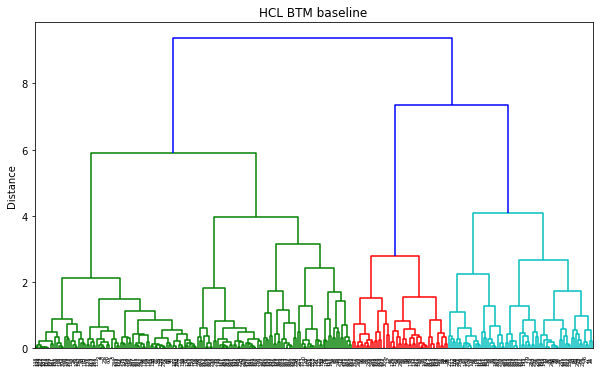

In [56]:
# distance matrix
Y0 = pdist(btm0.values[:, 1:], 'correlation')
# linkage matrix
Z0 = linkage(Y0, method='ward')

plt.figure(figsize=(10, 6))
plt.title('HCL BTM baseline')
plt.ylabel('Distance')
dendrogram(Z0)
plt.show()

In [57]:
# Note: run order matters in these code blocks

# based on the figure above, cut the tree at 1
btmClus0 = fcluster(Z0, 1, criterion='distance')

print(btmClus0)    # This is cluster number for each row in btm

number_features, number_clusters = len(btmClus0), len(set(list(btmClus0)))
print("number of features: ", number_features)
print("number of clusters: ", number_clusters)

# Compile clusters
btmClusDict = {}
for ii in range(number_features):
    if btmClusDict.has_key(btmClus0[ii]):
        btmClusDict[ btmClus0[ii] ].append(ii)
    else:
        btmClusDict[ btmClus0[ii] ] = [ii]
        
print(btmClusDict.items()[:3])    # This organizes cluster, members


[12  2  2  2  2  2 28 18  2 26  6 28 15 26 26  4 14 18  6 27 27 27 27 28 24
  4 28 28  2  4  4 13  1 24 28  4 24 24 19 13  6 26 19  1  4 19 11 27 19 12
 19 20 20 16 20 16 16 16 16 14  2 12 19 28 28  4  4  4  5 19  6  4  4 19  1
  3 28  2 22 22 22 22 22  4  4 14 19  3  1  4  4 20 19  1  1 21 27 27 22 16
 19 23  2  1  1 22 20  4 17  6  6  6  1 22  1 13 23  2  4 13 12 22  4 12 19
  1  4  1 17 19 19 15  2 19 19  6  9 21 20  6 22 13  8  1 27  7  3 27  1  1
  3 12  4  4  4  1 24  4  4  1 20  1 25  9 20 23  1  6  6 27  1  4 18 21 16
  6  5  2  2  1  7  6 12 12 10  6  6  1 24  4  1  4  6  3 26 26 27 12 19  9
 18  4  1 10  1  5 10 10  5 15 15 22  5  6 26 28  3 20  6 20  5 19  5  2 10
  6 12  4 12 17 10 21 27 27  6  6  2  4  5 25  6  6  4 25 15 25 14  8 27 26
 26 27 24 25 10 16 27 15  6 17  7  6 16 25 11 16  9 25 24 28 22 16  4  1 10
 24 22 26  2  4 19]
('number of features: ', 281)
('number of clusters: ', 28)
[(1, [32, 43, 74, 88, 93, 94, 103, 104, 112, 114, 125, 127, 143, 148, 149, 155, 159, 

In [58]:
metabo0 = pd.read_table(DataDir + 'HILIC_pos_baseline.txt')
metabo0.head()

,mz,time,N1,N2,N3,N4,N5,N6,SI1,SI2,SI3,SI4,SI5,SI6
0,85.028652,275.315404,22.765444,24.235381,22.974513,22.079431,22.782930,22.614064,22.317718,21.715938,21.846596,21.407006,22.507095,22.223187
1,85.028687,114.320308,21.633623,21.411211,16.839990,22.899276,22.352766,22.252941,20.274913,21.684780,21.748549,20.954136,21.531069,15.847699
2,85.047995,127.075639,21.557743,23.625242,22.562541,0.000000,21.934977,22.805880,21.805570,22.330632,21.862336,21.249401,20.989709,21.085978
3,85.065074,261.795854,26.652813,27.505616,26.353987,26.293264,25.872403,26.990890,25.806067,26.444982,25.865171,25.604309,25.590818,26.003205
4,85.076279,160.888279,22.943982,22.112600,23.329563,20.404194,21.293158,22.984413,22.395191,23.133225,21.895593,22.124032,21.944831,22.713366


((4236, 14), (8969730,))
('Vector delta_RT len: ', 8969730)


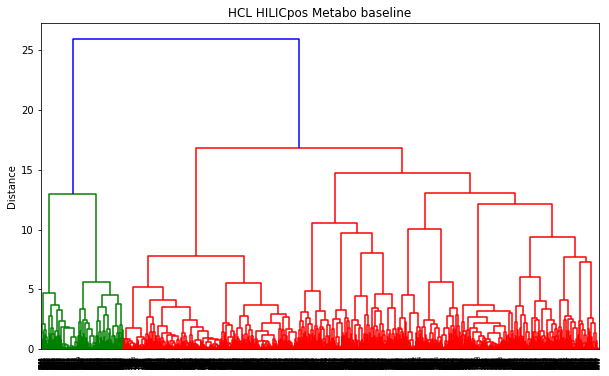

In [60]:
# Same weighted clustering method as above for metabo
# Copy & paste most code from above

# Note data starting from col 2!!!
YM = pdist(metabo0.values[:, 2:], 'correlation')
print(metabo0.shape, YM.shape)
retention_time = [float(x) for x in metabo0.values[:,1]]
min_retention_time, max_retention_time = min(retention_time), max(retention_time)
range_retention_time = max_retention_time - min_retention_time
#print("min_retention_time, max_retention_time", min_retention_time, max_retention_time)

PearsonR = 1 - YM
#print(PearsonR[:20])

delta_RT = []
for ii in range(metabo0.shape[0]):
    for jj in range(ii+1, metabo0.shape[0]):
        delta_RT.append(abs(retention_time[ii] - retention_time[jj]))        

print("Vector delta_RT len: ", len(delta_RT))

YM_new = 1 - (1- np.array(delta_RT)/range_retention_time)*PearsonR

# Metabolite features linkage matrix using new distance matrix
ZM = linkage(YM_new, method='ward')

plt.figure(figsize=(10, 6))
plt.title('HCL HILICpos Metabo baseline')
plt.ylabel('Distance')
dendrogram(ZM)
plt.show()

In [61]:
# repeat same procedure as earlier
# based on the figure above, cut the tree at 2
metClus = fcluster(ZM, 2, criterion='distance')
print(metClus[:3])   

number_features, number_clusters = len(metClus), len(set(list(metClus)))
print("number of features: ", number_features)
print("number of clusters: ", number_clusters)

# Compile clusters
metClusDict = {}
for ii in range(number_features):
    if metClusDict.has_key(metClus[ii]):
        metClusDict[ metClus[ii] ].append(ii)
    else:
        metClusDict[ metClus[ii] ] = [ii]
        
print(metClusDict.items()[:3])    # This organizes cluster, members

[79 97 67]
('number of features: ', 4236)
('number of clusters: ', 106)
[(1, [73, 119, 2363, 2719, 2752, 2865, 2921, 3011, 3068, 3164, 3242, 3287, 3295, 3652, 4016, 4194]), (2, [459, 706, 730, 1205, 1622, 1903, 2197, 2551, 2698, 2734, 2808, 2859, 2870, 2947, 3060, 3065, 3090, 3118, 3135, 3147, 3232, 3297, 3328, 3333, 3370, 3377, 3519, 3602, 3702, 3824, 3884, 3899, 3903, 3926, 4006, 4052, 4156, 4172, 4208, 4211, 4212, 4221, 4227]), (3, [19, 35, 44, 441, 641, 843, 1114, 1115, 1199, 1370, 1484, 3798])]


In [62]:
# do PLS regression on these baseline clusters
# Again, run order matters as we overwrote some variables

# Time the run
import time
start_time = time.time()

PLS = PLSRegression(n_components=3)
pls_scores = []

for g in btmClusDict.keys():
    if len(btmClusDict[g]) >= 3:
        #print(g,)
        for m in metClusDict.keys():
            if len(metClusDict[m]) >= 3:
                # Getting corresponding rows from btm and metabo. Subjs prematched.
                # Note data starting from 2nd OR 3rd col;
                matrix1, matrix2 = btm0.values[ btmClusDict[g], 1: ], metabo0.values[ metClusDict[m], 2: ]
                matrix1, matrix2 = np.transpose(matrix1), np.transpose(matrix2)
                # PLS regression
                PLS.fit(matrix1, matrix2)
                PLSscore = PLS.score(matrix1, matrix2)
                pls_scores.append(( g, m, PLSscore ))

with open('Baseline_TM_PLSscores.txt', 'w') as file:
    file.write( 'btm_Cluster_number\tmetabo_Cluster_number\tPLSscore\n' + '\n'.join([
        '\t'.join([str(ii) for ii in x]) for x in pls_scores
    ]) + '\n'
    )
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.81740999222 seconds ---


## With PLS scores, now do permutations
Each run of 30 * 100 returns 3000 scores. 500 runs do ~ 1.5 million permutations.
Given the ~10 seconds run time above, 10*500/60.0/60 = 1.4 hours on this laptop...

Resampling both features and sample labels. Matching cluster sizes.

In [70]:
# cluster sizes
gSizes = [len(x) for x in btmClusDict.values() if len(x) > 2]
mSizes = [len(x) for x in metClusDict.values() if len(x) > 2]
print len(gSizes), gSizes[:3], len(mSizes), mSizes[:3]

gArray0 = btm0.values[:,1:].flatten()
mArray0 = metabo0.values[:, 2:].flatten()

gArray = btm.values[:,1:].flatten()
mArray = metabo.values[:, 1:].flatten()

SampleNumber = 12

from random import sample as permutation
PLS = PLSRegression(n_components=3)

def do_permutations(gArray, mArray, N=500):
    # this overdoes mArray permutation
    scores = []
    for jj in range(N):
        for g in gSizes:
            matrix1 = []
            for ii in range(g):
                matrix1.append(permutation(gArray, SampleNumber))
            matrix1 = np.array(matrix1).T
            for m in mSizes:
                matrix2 = []
                for ii in range(m):
                    matrix2.append(permutation(mArray, SampleNumber))
                matrix2 = np.array(matrix2).T
                #
                PLS.fit(matrix1, matrix2)
                PLSscore = PLS.score(matrix1, matrix2)
                scores.append( PLSscore )

    return scores

def do_both(N=500):
    scores0 = do_permutations(gArray0, mArray0, N)
    with open('Permutation_scores_baseline.txt', 'w') as file:
        file.write('\n'.join([str(round(x,3)) for x in scores0]))
        
    scores = do_permutations(gArray, mArray, N)
    with open('Permutation_scores_diagVbasel.txt', 'w') as file:
        file.write('\n'.join([str(round(x,3)) for x in scores]))

start_time = time.time()
do_both(N=500)
print("--- %s seconds ---" % (time.time() - start_time))


# Note, --- 8699.34481311 seconds ---
# More appropariate way is to do PLS regression both directions. There's difference X predicting Y vs Y predicting X.


26 [26, 17, 6] 106 [16, 43, 12]
--- 8699.34481311 seconds ---


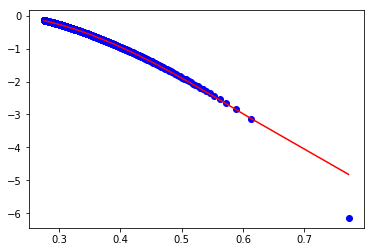

In [97]:
# look up p-values for PLS scores via a fitted polynomial function. Rank based method is too slow. 

permutation_list_baseline = [float(x) for x in open("Permutation_scores_baseline.txt").readlines()]
plslistlength = len(permutation_list_baseline)
permutation_list_baseline.sort(reverse=True)
N_positive = len([x for x in permutation_list_baseline if x >0])

# fit a function log10(p-value) = f(score). Rank based lookup too slow
fp = np.polyfit(permutation_list_baseline[:N_positive], 
                np.log10(np.arange(1,N_positive+1)/float(plslistlength)), 3)

def fp_predict(x, fp):
    return fp[0]*x**3 + fp[1]*x**2 + fp[2]*x + fp[3]

sparseY = np.arange(1, 1000000, 1000)
sparseX = [permutation_list_baseline[ii] for ii in sparseY]
plt.plot(sparseX, np.log10(sparseY/float(plslistlength)), 'bo')
plt.plot(sparseX, [fp_predict(x, fp) for x in sparseX], 'r-')
plt.show()

# Compute p-values
s = "btm_Cluster_number\tmetabo_Cluster_number\tPLSscore\tlog10(p-value)\n"

for line in open("Baseline_TM_PLSscores.txt").readlines()[1:]:
    a = line.rstrip().split('\t')
    score = float(a[2])
    if score > 0:   # Must ignore negative values
        log10p = fp_predict(score, fp)
        s += '\t'.join( a  + [str(log10p)]) + '\n'
    
with open("pvalues_Baseline_TM_PLSscores.txt", "w") as file:
    file.write(s)

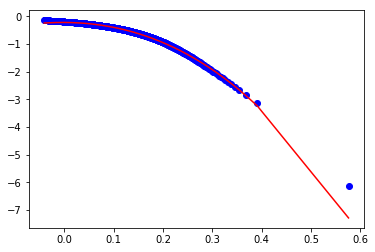

In [98]:
# do same for diag vs baseline data

permutation_list_2 = [float(x) for x in open("Permutation_scores_diagVbasel.txt").readlines()]
plslistlength = len(permutation_list_2)
permutation_list_2.sort(reverse=True)
N_positive = len([x for x in permutation_list_2 if x >0])

# fit a function log10(p-value) = f(score). Rank based lookup too slow
fp = np.polyfit(permutation_list_2[:N_positive], 
                np.log10(np.arange(1,N_positive+1)/float(plslistlength)), 3)

sparseY = np.arange(1, 1000000, 1000)
sparseX = [permutation_list_2[ii] for ii in sparseY]
plt.plot(sparseX, np.log10(sparseY/float(plslistlength)), 'bo')
plt.plot(sparseX, [fp_predict(x, fp) for x in sparseX], 'r-')
plt.show()

# Compute p-values
s = "btm_Cluster_number\tmetabo_Cluster_number\tPLSscore\tlog10(p-value)\n"

for line in open("diagnosisVbaseline_TM_PLSscores.txt").readlines()[1:]:
    a = line.rstrip().split('\t')
    score = float(a[2])
    if score > 0:   # Must ignore negative values
        log10p = fp_predict(score, fp)
        s += '\t'.join( a  + [str(log10p)]) + '\n'
    
with open("pvalues_diagnosisVbaseline_TM_PLSscores.txt", "w") as file:
    file.write(s)


In [105]:
# Function to retrieve clusters and members
# Too bad overwritten metClusDict and btmClusDict
# still have btmClus0, btmClus, metClus, metClus0

# have to redo this
metClus0 = fcluster(ZM, 2, criterion='distance')
metClus = metClus_redo

print(btm.shape, btm0.shape)

# btm_clus #19 at basl
goodrows = []
for ii in range(btm0.shape[0]):
    if btmClus0[ii] == 19:
        goodrows.append(ii)

btm0.iloc[goodrows, :].to_csv("btm0_clus19.txt", sep="\t")

wanted_clusters = [32, 34, 71, 81, 98]
for c in wanted_clusters:
    goodrows = []
    for ii in range(metabo0.shape[0]):
        if metClus0[ii] == c:
            goodrows.append(ii)

    metabo0.iloc[goodrows, :].to_csv("metabo0_clus_%d.txt" %c, sep="\t")

# moved these files to baseline_clusters
# separately made dirs


((281, 13), (281, 13))


In [109]:
#
def write_cluster(OUTDIR, wanted_clusters, metClus, metabo, prefix="metabo_"):
    for c in wanted_clusters:
        goodrows = []
        for ii in range(metabo.shape[0]):
            if metClus[ii] == c:
                goodrows.append(ii)

        metabo.iloc[goodrows, :].to_csv( OUTDIR + prefix + "clus_%d.txt" %c, sep="\t")
    
# now do diagVbaseline
wanted_g, wanted_m = [], []
for line in open("pvalues_diagnosisVbaseline_TM_PLSscores.txt").readlines()[1:]:
    a = line.split('\t')
    if line.strip() and float(a[3]) < -2:   # p < 0.01
        wanted_g.append( int(a[0] ))
        wanted_m.append( int(a[1]) )

# write btm clus
write_cluster("btm_clusters_diagVbasl/", wanted_g, btmClus, btm, prefix="btm_")
# write metabo clus
write_cluster("metabo_clusters_diagVbasl/", wanted_m, metClus, metabo, prefix="metabo_")


# Summary

* A good number of BTM clusters and metabo Clusters are associated at diagnosis/baseline
* Can make a network figure from "pvalues_diagnosisVbaseline_TM_PLSscores.txt". Figures in paper were made in Cytoscape and further edited.
* Metabolite cluster data can be run by mummichog for interpretation; clusters may be combined.